In [1]:
from utils import database

import re

import numpy as np
import pandas as pd

import folium as fl
from folium import plugins
import geopandas as gpd

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("classic")

In [2]:
properties = database.get_properties()

df = pd.DataFrame(
    properties, 
    columns=['title', 'letting', 'price', 'latitude', 'longitude', 'stations', 'url']
)

df['furnished'] = df['letting'].astype(str).str.extract(r"(:'.*')")
df['furnished'] = df['furnished'].str.replace('\W', '')

df['bedrooms'] = df['title'].str.extract(r"(\d{1,2})")

df['nearest_station_distance'] = df['stations'].astype(str).str.extract(r"(\d\.?\d?)").astype(float)

regex = r"""
    (flat|
    house|
    farm\sland|
    plot|
    apartment|
    equestrian|
    sheltered\shousing|
    lodge|
    triplex|
    gite|
    private\shalls|
    maisonette|
    finca|
    barn|
    property|
    chalet|
    bungalow|
    Land|
    duplex|
    cottage|
    garage|
    parking|
    private\shalls)
"""
regex = re.compile(regex, re.VERBOSE)

df['title'] = df['title'].str.lower()
df['type'] = df['title'].str.extract(regex)

df['share'] = df['title'].str.contains(r'share')


# Getting the payment interval
df['payment_interval'] = df['price'].str.split(" ").str.get(-1)

# Cleaning the payment interval name, since some values have the ")" character
df['payment_interval'] = df['payment_interval'].apply(lambda x : x.replace(")",""))

df['price_value'] = df['price'].str.split("£").str.get(1).str.split(" ").str.get(0).str.replace(",","").astype(np.float32)
df[['latitude','longitude']] = df[['latitude', 'longitude']].astype(np.float)

def convert_price(x):
    
    if x['payment_interval'] == 'pw':
        return x['price_value'] * 4
    else:
        return x['price_value']

df['monthly_price'] = df.apply(convert_price, axis=1)

london_districts = gpd.read_file("london.geojson")
london_districts['centroid_x'] = london_districts.geometry.centroid.x
london_districts['centroid_y'] = london_districts.geometry.centroid.y

properties_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=london_districts.crs)
df = gpd.sjoin(london_districts, properties_geo)

df = df.reset_index()
df.head()

index                  name  cartodb_id           created_at  \
0      0  Barking and Dagenham           1  2013-09-16T02:14:14   
1      0  Barking and Dagenham           1  2013-09-16T02:14:14   
2      0  Barking and Dagenham           1  2013-09-16T02:14:14   
3      0  Barking and Dagenham           1  2013-09-16T02:14:14   
4      0  Barking and Dagenham           1  2013-09-16T02:14:14   

            updated_at                                           geometry  \
0  2013-09-16T02:14:14  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...   
1  2013-09-16T02:14:14  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...   
2  2013-09-16T02:14:14  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...   
3  2013-09-16T02:14:14  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...   
4  2013-09-16T02:14:14  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...   

   centroid_x  centroid_y  index_right                          title  ...  \
0    0.133543   51.545269         8018         1 bedroom flat to rent  ...   
1    0.133543   51.545269        11867        2 bedroom house to rent  ...   
2    0.133543   51.545269        25030         2 bedroom flat to rent  ...   
3    0.133543   51.545269        24855         2 bedroom flat to rent  ...   
4    0.133543   51.545269        15969  1 bedroom house share to rent  ...   

                                            stations  \
0  [{'name': 'Chadwell Heath', 'distance': 0.5}, ...   
1  [{'name': 'Dagenham East', 'distance': 0.6}, {...   
2  [{'name': 'Dagenham East', 'distance': 0.7}, {...   
3  [{'name': 'Dagenham East', 'distance': 0.7}, {...   
4  [{'name': 'Becontree', 'distance': 0.9}, {'nam...   

                                                 url      furnished  bedrooms  \
0  https://www.rightmove.co.uk/property-to-rent/p...    Unfurnished         1   
1  https://www.rightmove.co.uk/property-to-rent/p...    Unfurnished         2   
2  https://www.rightmove.co.uk/property-to-rent/p...    Unfurnished         2   
3  https://www.rightmove.co.uk/property-to-rent/p...    Unfurnished         2   
4  https://www.rightmove.co.uk/property-to-rent/p...  Partfurnished         1   

  nearest_station_distance   type  share payment_interval  price_value  \
0                      0.5   flat  False              pcm        925.0   
1                      0.6  house  False              pcm       1300.0   
2                      0.7   flat  False              pcm       1175.0   
3                      0.7   flat  False              pcm       1175.0   
4                      0.9  house   True              pcm        475.0   

  monthly_price  
0         925.0  
1        1300.0  
2        1175.0  
3        1175.0  
4         475.0  

[5 rows x 24 columns]

# Null values

In [3]:
null_values = {
        column:df
    [column].isnull().sum() 
        for column in df
}

null_values

{'index': 0,
 'name': 0,
 'cartodb_id': 0,
 'created_at': 0,
 'updated_at': 0,
 'geometry': 0,
 'centroid_x': 0,
 'centroid_y': 0,
 'index_right': 0,
 'title': 0,
 'letting': 0,
 'price': 0,
 'latitude': 0,
 'longitude': 0,
 'stations': 0,
 'url': 0,
 'furnished': 4023,
 'bedrooms': 2333,
 'nearest_station_distance': 12,
 'type': 4,
 'share': 0,
 'payment_interval': 0,
 'price_value': 7,
 'monthly_price': 7}

In [4]:
df = df[df['type'].isin(['flat', 'apartment', 'house'])]

# Removing values with null prices
df = df[~df['price_value'].isnull().values]
df = df[~df['bedrooms'].isnull().values]

df['bedrooms'] = df['bedrooms'].astype(int)

df.loc[df['furnished'].isnull() , 'furnished'] = 'Unknown'
df[df['furnished'].isnull()]

# TODO evaluate whether the below option is feasible
# TODO Create an AI model to predict the amount of bedrooms for each property
dd = df[df['bedrooms'].isnull()]

df.loc[df['nearest_station_distance'].isnull(), 'nearest_station_distance']  = df['nearest_station_distance'].mean()

# Distribution of payment interval

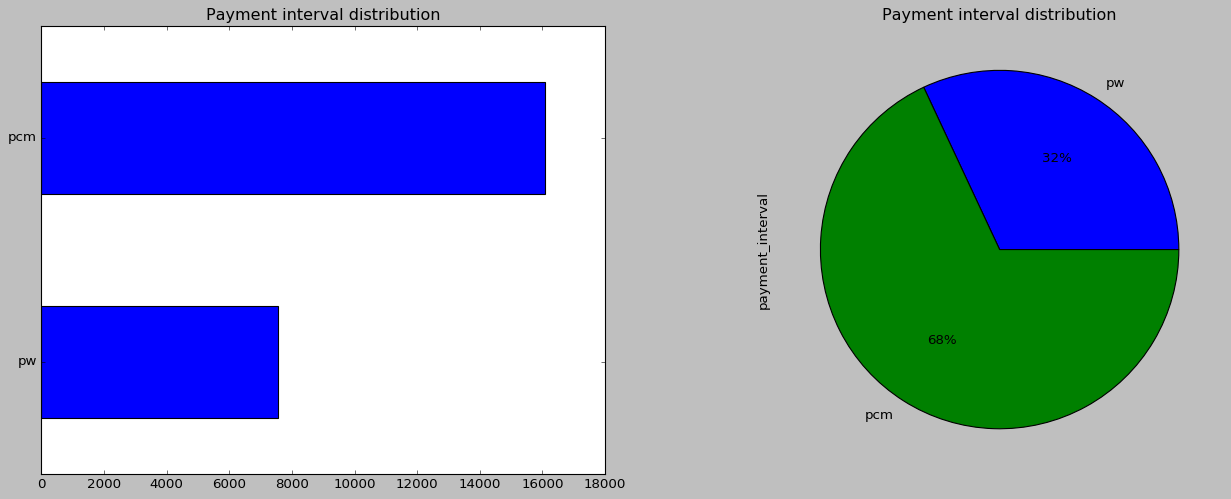

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

values = df['payment_interval'].value_counts().sort_values()
values.plot(kind='barh', title="Payment interval distribution", ax=ax[0])
values.plot(kind='pie', title="Payment interval distribution", ax=ax[1], autopct='%1.0f%%')


plt.show()

# Distribution by district

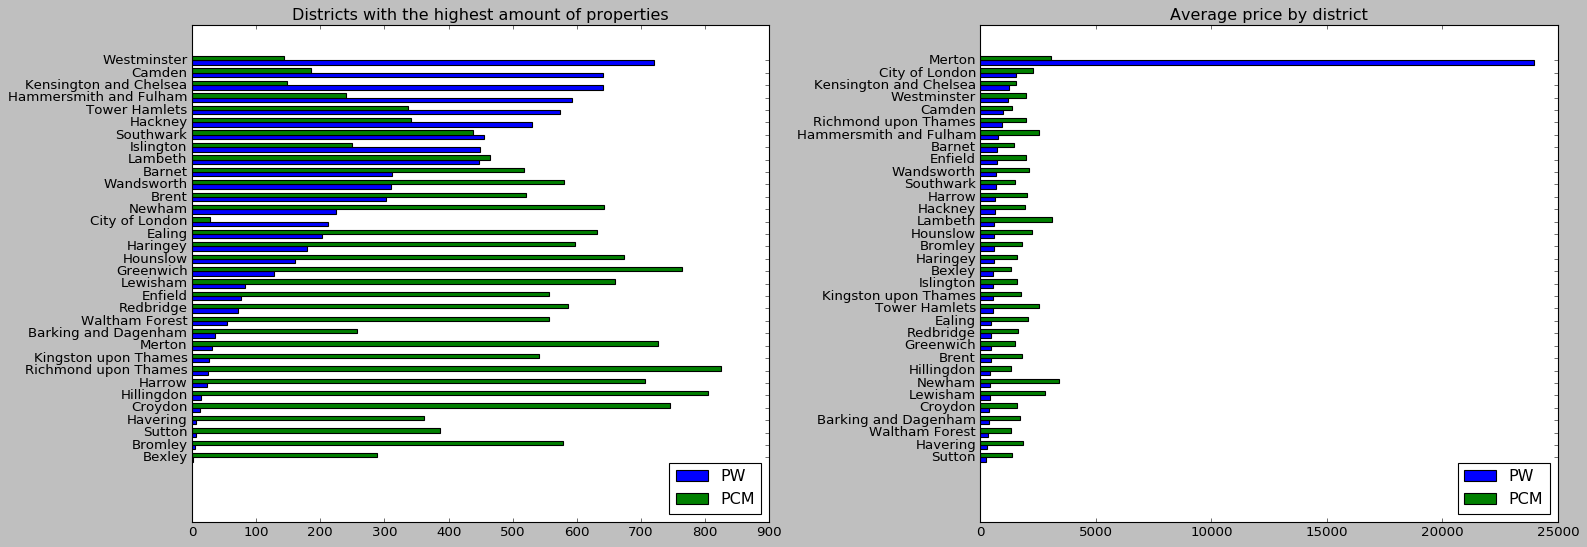

In [6]:
pw = df[df['payment_interval'] == 'pw']
pcm = df[df['payment_interval'] == 'pcm']

pw_distribution = pw['name'].value_counts().sort_values()
pcm_distribution = pcm['name'].value_counts().sort_values()
pcm_distribution = pcm_distribution.loc[ pw_distribution.index.values ]


fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ind = np.arange(len(pcm_distribution))    # the x locations for the groups
width = 0.35

p1 = ax[0].barh(ind, pw_distribution.values, width)
p2 = ax[0].barh(ind + width, pcm_distribution.values, width)

ax[0].set_title('Districts with the highest amount of properties')
ax[0].set_yticks(ind + width / 2)
ax[0].set_yticklabels(pw_distribution.index.values)
ax[0].legend((p1[0], p2[0]), ('PW', 'PCM'), loc='lower right')


pw_average_price = pw.groupby('name', as_index=False)['price_value'].mean().sort_values(by='price_value')
pcm_average_price = pcm.groupby('name', as_index=False)['price_value'].mean()

ind = np.arange(len(pcm_average_price))    # the x locations for the groups
width = 0.35

p1 = ax[1].barh(ind, pw_average_price['price_value'], width)
p2 = ax[1].barh(ind + width, pcm_average_price['price_value'], width)

ax[1].set_title('Average price by district')
ax[1].set_yticks(ind + width / 2)
ax[1].set_yticklabels(pw_average_price.name.values)
ax[1].legend((p1[0], p2[0]), ('PW', 'PCM'), loc='lower right')

fig.tight_layout()

plt.show()

In [7]:
pcm_average_price

name  price_value
0     Barking and Dagenham  1342.515503
1                   Barnet  1829.308838
2                   Bexley  1299.597168
3                    Brent  1708.023071
4                  Bromley  1579.100342
5                   Camden  2778.805420
6           City of London  3417.714355
7                  Croydon  1304.770508
8                   Ealing  1783.310669
9                  Enfield  1505.551147
10               Greenwich  1638.527466
11                 Hackney  2046.798218
12  Hammersmith and Fulham  2542.225098
13                Haringey  1760.504150
14                  Harrow  1601.218140
15                Havering  1300.781738
16              Hillingdon  1583.077148
17                Hounslow  1816.173828
18               Islington  2216.313232
19  Kensington and Chelsea  3110.885254
20    Kingston upon Thames  1930.914917
21                 Lambeth  2017.517212
22                Lewisham  1484.302002
23                  Merton  2086.553711
24                  Newham  1962.559937
25               Redbridge  1452.102417
26    Richmond upon Thames  2525.019531
27               Southwark  1965.595947
28                  Sutton  1348.518188
29           Tower Hamlets  1990.210693
30          Waltham Forest  1536.649292
31              Wandsworth  2275.800049
32             Westminster  3052.298584

Regarding the left plot :

Why this behavior happens ? Is it related to the lack of data ?  The obvius pattern would be same categories following the same distribution...

Does it happen because of the tourists ? Westminter has a lot of attractions ....


Regarding the right plot :

It's clear the data is being influenced by outliers ..

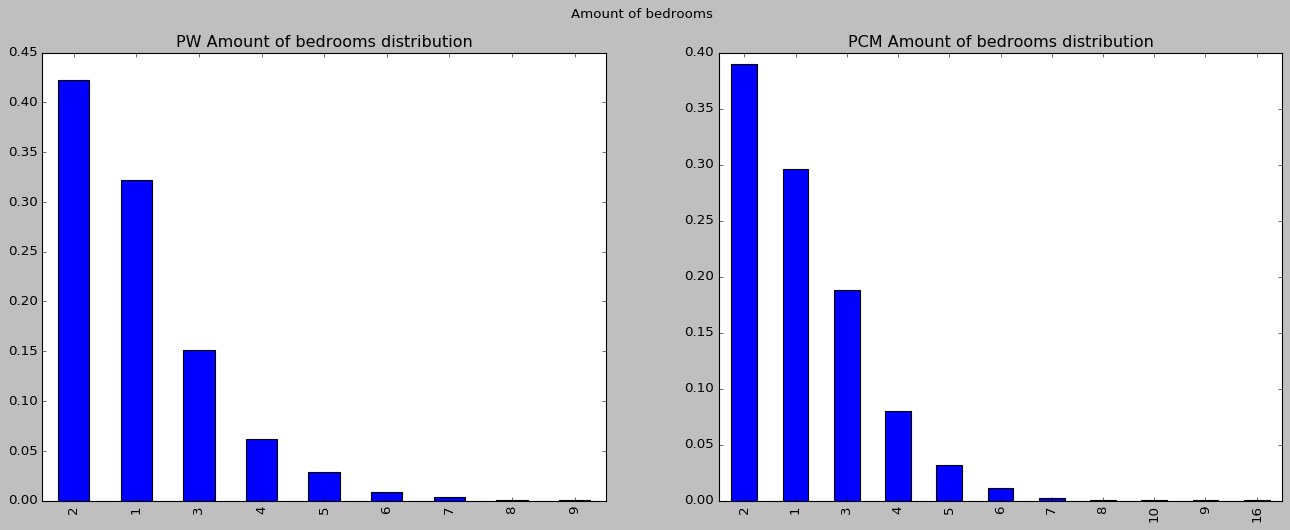

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

pw['bedrooms'].value_counts(normalize=True).plot(kind='bar', ax=ax[0], title="PW Amount of bedrooms distribution")
pcm['bedrooms'].value_counts(normalize=True).plot(kind='bar', ax=ax[1], title="PCM Amount of bedrooms distribution")

fig.suptitle("Amount of bedrooms")

plt.show()

In [9]:
pcm[(pcm['type'] == 'house') & (pcm['name'] == 'Bexley')]

index    name  cartodb_id           created_at           updated_at  \
1301      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1302      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1304      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1306      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1307      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
...     ...     ...         ...                  ...                  ...   
1611      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1641      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1643      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1644      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   
1645      2  Bexley           3  2013-09-16T02:14:14  2013-09-16T02:14:14   

                                               geometry  centroid_x  \
1301  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1302  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1304  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1306  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1307  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
...                                                 ...         ...   
1611  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1641  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1643  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1644  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   
1645  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...    0.140366   

      centroid_y  index_right                                  title  ...  \
1301   51.458824        19595                1 bedroom house to rent  ...   
1302   51.458824         9073                1 bedroom house to rent  ...   
1304   51.458824        23039       2 bedroom terraced house to rent  ...   
1306   51.458824         7375  3 bedroom semi-detached house to rent  ...   
1307   51.458824        14000                6 bedroom house to rent  ...   
...          ...          ...                                    ...  ...   
1611   51.458824         7347                2 bedroom house to rent  ...   
1641   51.458824         1808  4 bedroom semi-detached house to rent  ...   
1643   51.458824        13145       2 bedroom terraced house to rent  ...   
1644   51.458824        11343                2 bedroom house to rent  ...   
1645   51.458824        24881  3 bedroom semi-detached house to rent  ...   

                                               stations  \
1301  [{'name': 'Abbey Wood', 'distance': 0.6}, {'na...   
1302  [{'name': 'Abbey Wood', 'distance': 0.6}, {'na...   
1304  [{'name': 'Abbey Wood', 'distance': 0.2}, {'na...   
1306  [{'name': 'Belvedere', 'distance': 0.0}, {'nam...   
1307  [{'name': 'Abbey Wood', 'distance': 0.4}, {'na...   
...                                                 ...   
1611  [{'name': 'Bexley', 'distance': 0.7}, {'name':...   
1641  [{'name': 'Crayford', 'distance': 0.5}, {'name...   
1643  [{'name': 'Sidcup', 'distance': 1.4}, {'name':...   
1644  [{'name': 'Sidcup', 'distance': 1.4}, {'name':...   
1645  [{'name': 'Sidcup', 'distance': 1.3}, {'name':...   

                                                    url  \
1301  https://www.rightmove.co.uk/property-to-rent/p...   
1302  https://www.rightmove.co.uk/property-to-rent/p...   
1304  https://www.rightmove.co.uk/property-to-rent/p...   
1306  https://www.rightmove.co.uk/property-to-rent/p...   
1307  https://www.rightmove.co.uk/property-to-rent/p...   
...                                                 ...   
1611  https://www.rightmove.co.uk/property-to-rent/p...   
1641  https://www.rightmove.co.uk/property-to-rent/p...   
1643  https://www.rightmove.co.uk/property-to-rent/p...   
1644

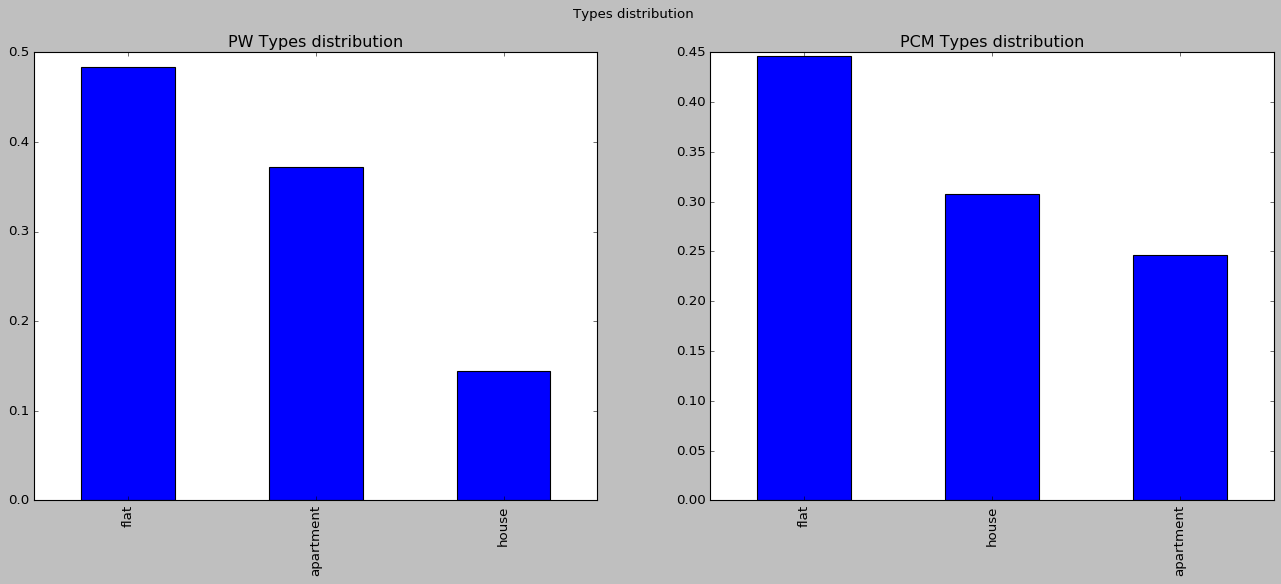

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

pw['type'].value_counts(normalize=True).plot(kind='bar', ax=ax[0], title="PW Types distribution")
pcm['type'].value_counts(normalize=True).plot(kind='bar', ax=ax[1], title="PCM Types distribution")

fig.suptitle("Types distribution")

plt.show()

# District average price

In [11]:
district_average_price = df.groupby('name', as_index=False)['price_value'].mean()

# Add the district coordinates
avg_price_df = london_districts.merge(district_average_price, on="name")

m = fl.Map(
    location=[51.518055, -0.181273],
    zoom_start=10,
    zoom_control=False
)

fl.Choropleth(
    geo_data = avg_price_df,
    name="geometry",
    data=avg_price_df,
    columns=['name', 'price_value'],
    fill_color="YlOrRd",
    key_on="feature.properties.name",
    legend_name = 'Properties monthly rent price'
).add_to(m)

[
    fl.Marker(
        location=[row['centroid_y'], row['centroid_x']],
        popup=row['name'] 
    ).add_to(m)
    
    for ix, row in london_districts.iterrows()
]

display(m)

/home/marco/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Detecting outliers

In [73]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


In [149]:
X = df[['name', 'nearest_station_distance', 'share', 'furnished', 'bedrooms', 'type', 'payment_interval', 'price_value']]
X = pd.get_dummies(X)

model = LocalOutlierFactor(novelty=True)
model.fit(X)

df['outlier_score'] = model.decision_function(X)
slc = df[['outlier_score', 'name', 'nearest_station_distance', 'share', 'furnished', 'bedrooms', 'type', 'payment_interval', 'price_value', 'url']]
slc.sort_values(by='outlier_score').to_csv("outliers.csv")

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [150]:
slc.sort_values(by='outlier_score').iloc[358].url

'https://www.rightmove.co.uk/property-to-rent/property-76133395.html'

In [151]:
testing = X.iloc[1]

In [152]:
testing['price_value'] = 0

/home/marco/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [170]:
model.predict([testing, testing])

array([1, 1])

In [169]:
testing['price_value'] = 150
testing['bedrooms'] = 1
testing['share'] = False


# Give more importance for the price_value feature
# It needs to consider pw/pcm variations

/home/marco/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/marco/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marco/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel pac